In [1]:
import numpy as np
from QAM_EncoderDecoder import * 
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
from util import *
from Functions import *
%matplotlib inline

In [2]:
withllrs_modification = False

Creating known ofdm frame
input_bit_length: 754200
encoding 776th LDPC block, 777 in total(1328, 2304) 133
3366144


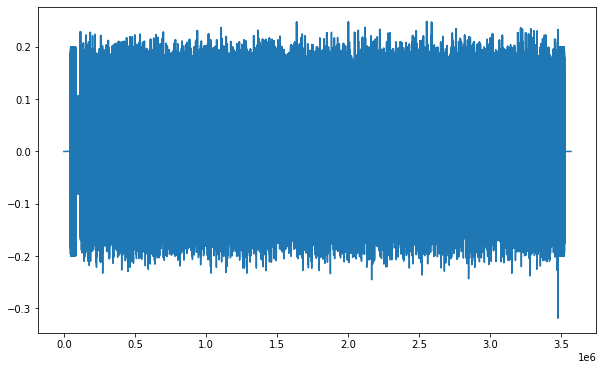

In [3]:
tx_signal, chirp, inverse_chirp,  known_frames, carrier_indices, bits_tran = create_tx_waveform('test_files/shakespeare.txt')
plt.figure(figsize=(10,6))
plt.plot(tx_signal)

filename = 'sound_files/transmit.wav'
sf.write(filename, tx_signal, fs)

In [4]:
rx_signal = real_channel_response_file("sound_files/Rec47.m4a")
'''
channel = np.load('channel_imp.npy')
channel -= np.average(channel)
rx_signal = np.convolve(tx_signal, channel)
'''

"\nchannel = np.load('channel_imp.npy')\nchannel -= np.average(channel)\nrx_signal = np.convolve(tx_signal, channel)\n"

In [5]:
rx_convolution_1, rx_convolution_2, peak_start, peak_end = matched_filter(rx_signal, inverse_chirp, chirp)

Manual for test purpose, not practical in real test since tx_wave is unknown

In [6]:

expected_ch_gap = len(tx_signal) - len(inverse_chirp) - 2*fs
actual_ch_gap = peak_end - peak_start

sampling_ratio = actual_ch_gap / expected_ch_gap
#extra_sample_after = int((1/(sampling_ratio-1)))

print("Actual sampling frequency: ", 44100*sampling_ratio)
#print("Extra sample after every", extra_sample_after , "samples")

Actual sampling frequency:  44100.06418115327


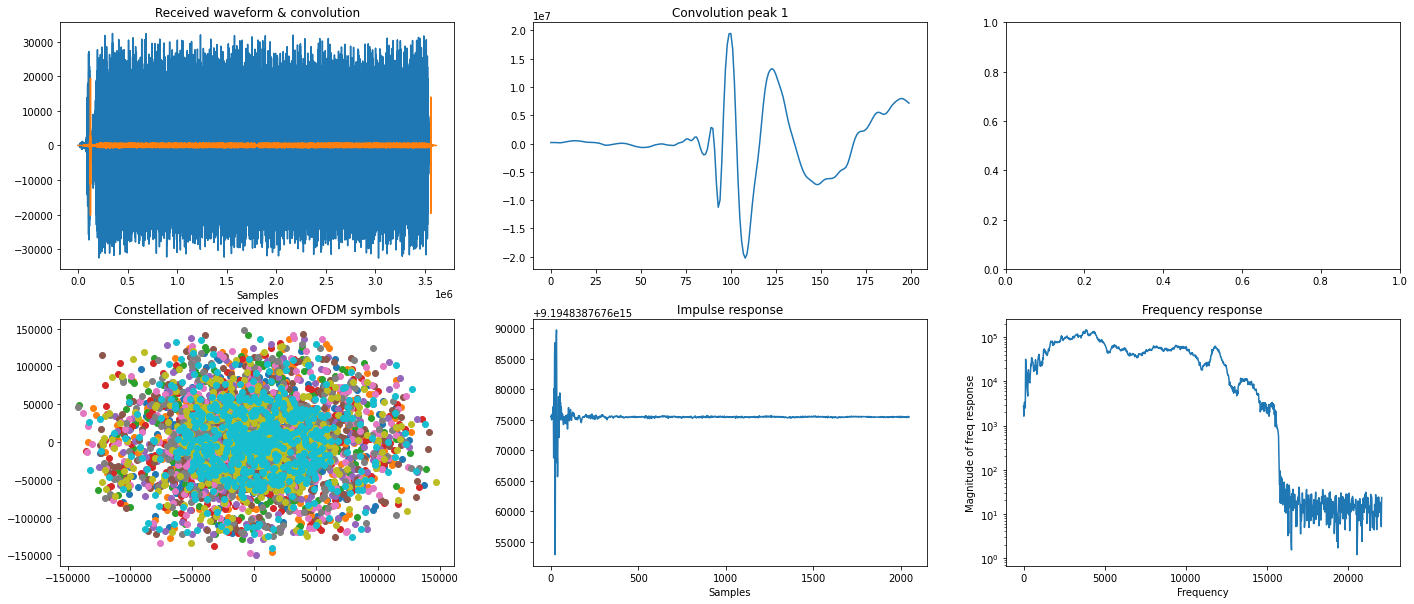

In [7]:

offset = 30
freq_response, imp_response, rx_known_frames = channel_estimate(rx_signal, peak_start, known_frames, offset)
figs, axs = plt.subplots(2, 3, figsize=(24,10))
axs[0][0].plot(rx_signal)
axs[0][0].set_title('Received waveform & convolution')
axs[0][0].plot(np.concatenate((rx_convolution_1[:-44100]/1000, rx_convolution_2/1000), axis=None))
axs[0][0].set_xlabel('Samples')
axs[0][1].set_title('Convolution peak 1')
axs[0][1].plot(rx_convolution_1[peak_start-100:peak_start+100])


for i in range(len(rx_known_frames)):
    tst_symbols = np.fft.fft(rx_known_frames[i][prefix_no:], N)[1:N//2]
    axs[1][0].scatter(np.real(tst_symbols), np.imag(tst_symbols), label=i)
axs[1][0].set_title('Constellation of received known OFDM symbols')

axs[1][1].set_title('Impulse response')
axs[1][1].set_xlabel('Samples')
axs[1][1].plot(imp_response)
axs[1][2].set_title('Frequency response')
axs[1][2].set_ylabel('Magnitude of freq response')
axs[1][2].set_xlabel('Frequency')
axs[1][2].semilogy(np.linspace(1, fs//2 -1, N//2-2), np.abs(freq_response[1:N//2-1]))

In [8]:
data_begin = peak_start + 11*(N+prefix_no) - offset # as 1 random & 10 known ofdm frames after chirp
data_end = peak_end - len(inverse_chirp) - offset # use end chirp to determine signal length for now, will need a fix later
# potential for data_being -> data_end to not be the correct length
print(data_end - data_begin)
print(len(tx_signal)-2*fs-2*len(inverse_chirp)-(N+prefix_no))
rx_data_full = rx_signal[data_begin:data_end - (actual_ch_gap - expected_ch_gap)]
rx_data_frames = np.split(rx_data_full, len(rx_data_full)/(N+prefix_no))

3366149
3389184


In [9]:
data_symbols, pilot_symbols, bits_rec = correct_phase_decode_data_ldpc(rx_data_frames, carrier_indices, freq_response)
#print(error_rate(bits_tran, bits_rec))

inside LDPC_decode_with_niceCKs
type(ys_)= <class 'numpy.ndarray'>
type(cks)= <class 'numpy.ndarray'>
about to ys_=ys_/ cks
ys_=ys_/ cks finished
about to do ys=separate_real_img(ys_)
about to do divide_codebits
about to loop
decoding 0th LDPC block, 778 in total tif= 0  txt= 3  wav= 0
file_type:  .txt

total_length:  1508400  bits to decode.
file_length: 754200
decoding 776th LDPC block, 778 in totalreturn [LDPCstr_decoded,file_type] , please check you have two parameters ready before the = (e.g. decoded, filetype = LDPC_decode_....)

about to write file, the filename inputed is:  Decode/decode19_22.txt
bitstr written to  Decode/decode19_22.txt


Found best Offset: 44 Found bets score: 101.38899613899615
inside LDPC_decode_with_niceCKs
type(ys_)= <class 'numpy.ndarray'>
type(cks)= <class 'numpy.ndarray'>
about to ys_=ys_/ cks
ys_=ys_/ cks finished
about to do ys=separate_real_img(ys_)
about to do divide_codebits
about to loop
decoding 0th LDPC block, 778 in total tif= 0  txt= 3  wav= 0
file_type:  .txt

total_length:  1508400  bits to decode.
file_length: 754200
decoding 776th LDPC block, 778 in totalreturn [LDPCstr_decoded,file_type] , please check you have two parameters ready before the = (e.g. decoded, filetype = LDPC_decode_....)

about to write file, the filename inputed is:  Decode/decode19_23.txt
bitstr written to  Decode/decode19_23.txt
0.0008485812781755502


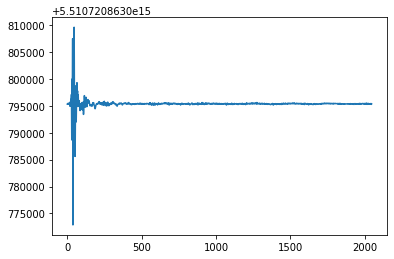

In [10]:
bits_rec, best_imp_response = fine_tuning(rx_signal, peak_start, peak_end, known_frames, inverse_chirp, carrier_indices, withllrs_modification=withllrs_modification, find_range=30, offset=20, LDPC_on=True)
print(error_rate(bits_tran,bits_rec))
plt.plot(best_imp_response)